In [10]:
import glob
import random
import IPython.display as ipd
from matplotlib import pyplot as plt
import librosa
import librosa.display
import numpy as np
import os
import csv
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import scipy.io.wavfile
import scipy.fft
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.neural_network import MLPClassifier
import joblib
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV




In [15]:
genres = []
path_audios = []
GENRE_DIR = 'genres_original/'
dirs = 'genres_original/*/*'
for i in glob.glob(dirs):
    if glob.glob(i)[0][-4:] == ".wav":
        path_audios.append(i,)
        genres.append([i][0].split("\\")[1].split(".")[0])
sample = dict(zip(genres, path_audios))
print(path_audios)
print(genres)

['genres_original\\classical\\classical.00000.wav', 'genres_original\\classical\\classical.00001.wav', 'genres_original\\classical\\classical.00002.wav', 'genres_original\\classical\\classical.00003.wav', 'genres_original\\classical\\classical.00004.wav', 'genres_original\\classical\\classical.00005.wav', 'genres_original\\classical\\classical.00006.wav', 'genres_original\\classical\\classical.00007.wav', 'genres_original\\classical\\classical.00008.wav', 'genres_original\\classical\\classical.00009.wav', 'genres_original\\classical\\classical.00010.wav', 'genres_original\\classical\\classical.00011.wav', 'genres_original\\classical\\classical.00012.wav', 'genres_original\\classical\\classical.00013.wav', 'genres_original\\classical\\classical.00014.wav', 'genres_original\\classical\\classical.00015.wav', 'genres_original\\classical\\classical.00016.wav', 'genres_original\\classical\\classical.00017.wav', 'genres_original\\classical\\classical.00018.wav', 'genres_original\\classical\\c

Dans la cellule précédante, on crée une liste contenant les genres et une autre contenant les noms de fichiers , puis on crée un dictionaire qui combine les deux listes ayant le genre comme clés et les noms de fichiers comme diffèrentes valeurs pour les clés.

In [16]:
_, value = random.choice(list(sample.items()))
print(_)
ipd.Audio(value)

jazz


Dans cette cellule, on choisit alèatoirement un audio depuis le data set et on affiche le genre et l'audio lui meme grace à IPython.display qui crée un objet audio à partir du chemin spécifié

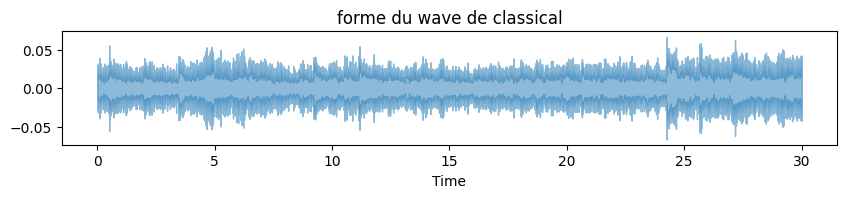

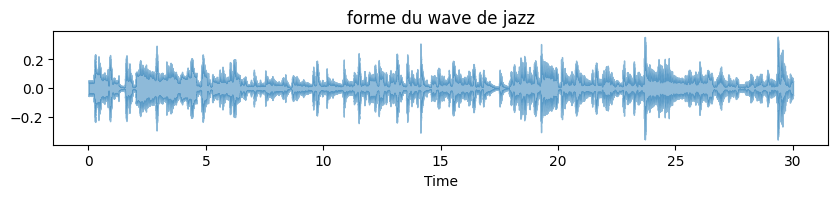

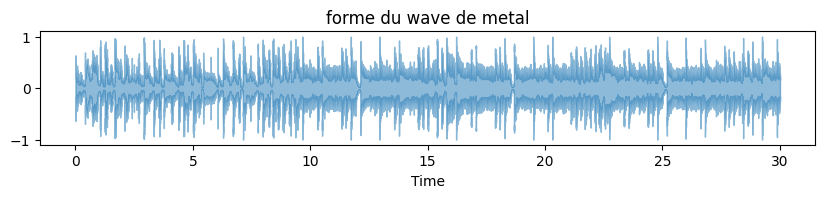

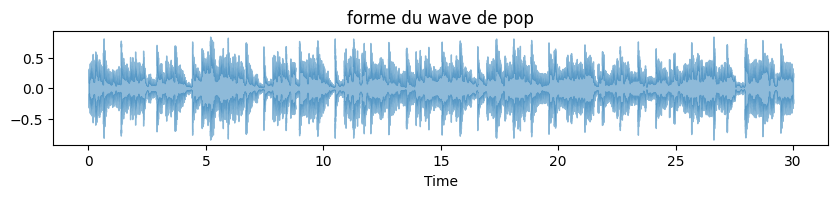

In [17]:
for genre, audio in sample.items():
    plt.figure(figsize=(10,5))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(librosa.load(audio)[0], alpha=0.5)
    plt.title("forme du wave de "+genre)

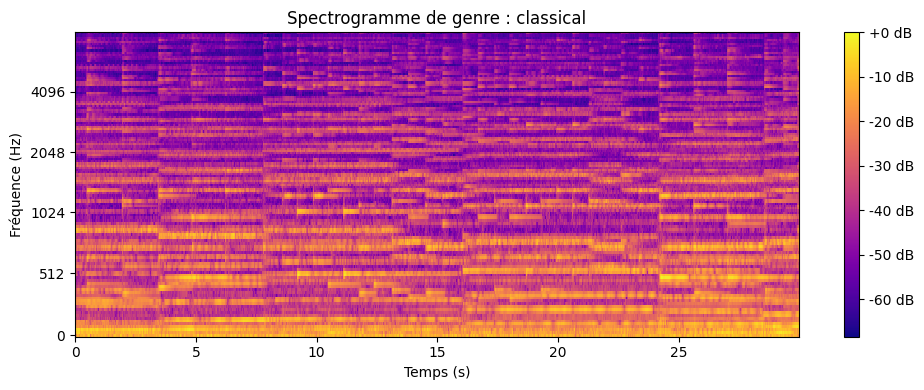

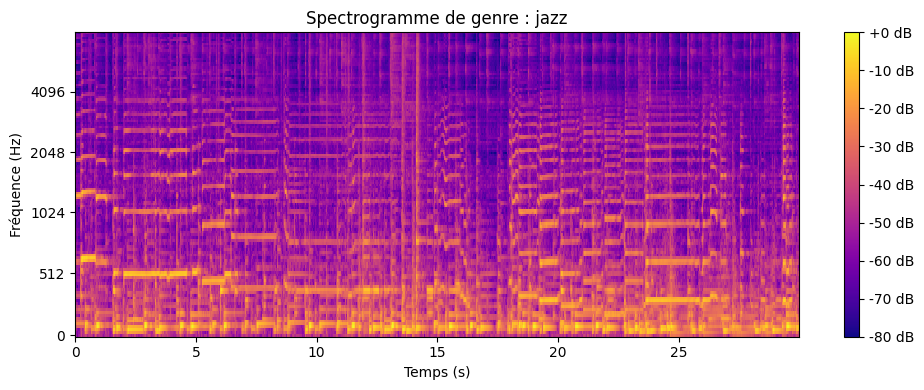

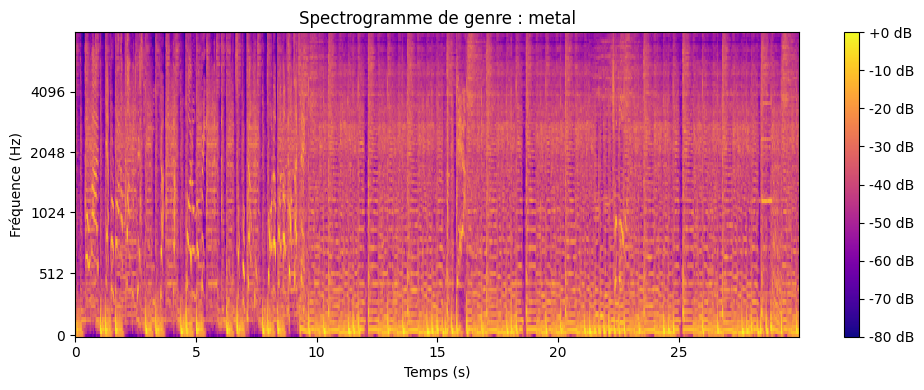

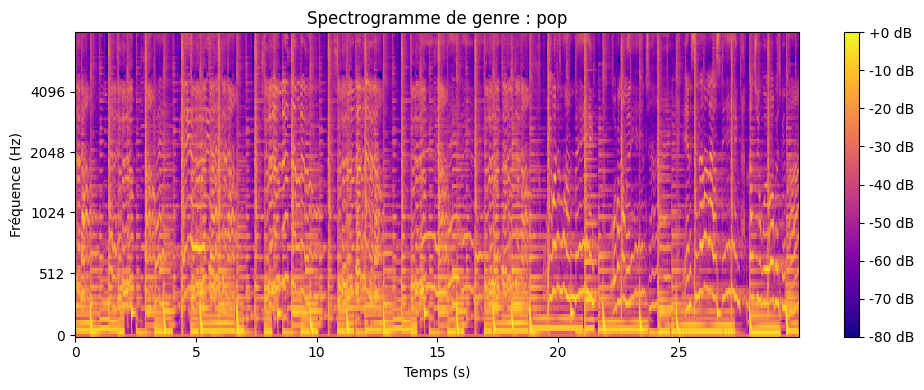

In [18]:
for genre,audio in sample.items():
    y, sr = librosa.load(audio, duration=30)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)  # Convertir en décibels pour une meilleure visualisation

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='plasma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogramme de genre : {genre}")
    plt.xlabel("Temps (s)")
    plt.ylabel("Fréquence (Hz)")
    plt.tight_layout()
    plt.show()


Cette cellule permet de visualiser les différents forme de vagues de chaque genre afin d'apercevoir leurs diffèrences grace à librosa.display.waveform().

In [19]:
data_csv = 'data.csv'
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 11):
    header += f' mfcc{i}'
for j in range(1, 11):
    header += f' rcep{j}'
header += ' label'
header = header.split()
file = open(data_csv, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

Création du dataset (nom,colonne,...) et génération des feautures

In [20]:
for genre in sample:
    for filename in os.listdir(f'genres_original/{genre}'):
         if filename.endswith('.wav'):
            songname = f'genres_original/{genre}/{filename}'
            y, sr = librosa.load(songname, mono=True, duration=30) 
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)[:10]
            D = np.abs(librosa.stft(y))**2  # Spectrogramme de puissance
            log_spectrum = np.log(np.maximum(D, 1e-10))  # Éviter les log(0)
            rceps = np.real(np.fft.ifft(log_spectrum, axis=0))  # Transformée de Fourier inverse
            rceps_mean = np.mean(rceps[:10], axis=1)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            for j in rceps_mean:
                to_append += f' {j}' 
            to_append += f' {genre}'
            file = open(data_csv, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())


# librosa.load => retourne un tableau NumPy contenant les échantillons du signal audios et le taux d'échantillonag du fichier pour capturer le signal avec précision
# chroma_stft => calcule les intensités pour 12 classses de pitch (Do,Ré,Mi, ...)
# rms => tableau NumPy contenant les échantillons du signal audios et le taux d'échantillonag du fichier
# spectral Centroid => Mesure la brillance d'un son (aigus = centroide élevé)
# spectral bandwidth =>  Indique si le signal est concentré autour de certaines fréquences ou réparti sur une plage plus large.
# spectral Rolloff =>  Indique la limite des hautes fréquences et peut être utilisé pour distinguer les sons aigus et graves.
# Zero Crossing Rate => Indique  le caractère percussif d'un son.
# MFCC => représente l'énergie spectral sur échelle de Mel qui modèlise la perception humaine des fréquences.

In [2]:
data = pd.read_csv("data.csv")
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,rcep2,rcep3,rcep4,rcep5,rcep6,rcep7,rcep8,rcep9,rcep10,label
0,classical.00000.wav,0.252380,0.036244,1505.377700,1559.085950,2717.316902,0.098245,-268.180023,135.687881,-34.071072,...,-0.446079,-0.315707,-0.046887,0.016423,0.088783,0.050434,0.041755,0.035760,0.061826,classical
1,classical.00001.wav,0.215047,0.030615,1360.596448,1441.389948,2387.977227,0.087772,-324.091949,133.594131,-25.021385,...,-0.322237,-0.125299,0.054765,0.045633,0.121098,0.050668,0.036999,0.000724,0.052930,classical
2,classical.00002.wav,0.277848,0.043841,1490.014795,1599.803415,2784.949826,0.090050,-235.306427,141.136749,-34.679047,...,-0.536855,-0.357810,-0.058040,-0.005997,0.099777,0.045657,0.050543,0.039346,0.051359,classical
3,classical.00003.wav,0.234234,0.029436,1526.560671,1499.533731,2915.690703,0.108952,-326.899872,127.394180,-30.584469,...,-0.343365,-0.130422,0.044605,0.084223,0.087189,0.128091,0.082041,0.003847,0.025474,classical
4,classical.00004.wav,0.221580,0.042288,1705.732427,1646.256508,3176.230794,0.112867,-259.962280,118.932381,-35.606533,...,-0.579103,-0.413563,-0.057854,0.060363,0.083499,0.111232,0.005213,-0.005019,0.006574,classical


# cette fonction permet d'extraire les caractéristiques basées sur la Transformée de Fourier Rapide et les stocker dans des fichiers binaires Numpy ".npy" 

In [22]:
def create_fft(fn):
    if not os.path.exists(fn):
        return 
    sample_rate, X = scipy.io.wavfile.read(fn)
    if len(X.shape) > 1:
        X = X.mean(axis=1)
    fft_features = abs(scipy.fft.fft(X)[:20]) 
    base_fn, ext = os.path.splitext(fn)
    data_fn = base_fn + ".fft.npy"
    np.save(data_fn, fft_features)
audiofiles = pd.DataFrame(path_audios, columns=["files"])
audiofiles["files"].apply(create_fft) 

0      None
1      None
2      None
3      None
4      None
       ... 
394    None
395    None
396    None
397    None
398    None
Name: files, Length: 399, dtype: object

# Dans cette partie on va extraire les caractéristiques des audios puis l'ajouter à notre dataset

In [23]:
def add_fft_features(row, fft_dir):
    base_fn = os.path.splitext(os.path.basename(row["filename"]))[0]
    fft_file = glob.glob(os.path.join(fft_dir, "**", base_fn + ".fft.npy"), recursive=True)
    if fft_file:
        fft_features = np.load(fft_file[0])
        for i, value in enumerate(fft_features):
            row[f"fft_{i}"] = value
    return row
fft_dir = "genres_original"
dataset = pd.read_csv("data.csv")
dataset = dataset.apply(add_fft_features, fft_dir=fft_dir, axis=1)
dataset.to_csv("dataset_avec_fft.csv", index=False)

In [3]:
data = pd.read_csv("dataset_avec_fft.csv")
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,fft_10,fft_11,fft_12,fft_13,fft_14,fft_15,fft_16,fft_17,fft_18,fft_19
0,classical.00000.wav,0.252380,0.036244,1505.377700,1559.085950,2717.316902,0.098245,-268.180023,135.687881,-34.071072,...,191922.158019,34957.845276,208159.396035,228862.127547,358567.914847,266612.000805,138452.501588,214932.233218,248116.978167,175240.599040
1,classical.00001.wav,0.215047,0.030615,1360.596448,1441.389948,2387.977227,0.087772,-324.091949,133.594131,-25.021385,...,74642.218509,40263.295608,94579.908282,15082.433725,93288.132980,159953.852792,61317.621669,197603.018527,112069.321523,54840.522211
2,classical.00002.wav,0.277848,0.043841,1490.014795,1599.803415,2784.949826,0.090050,-235.306427,141.136749,-34.679047,...,22627.784997,107278.791389,48944.664017,157152.126073,57369.711886,168845.213182,144354.484209,127505.640452,152096.714231,311230.104982
3,classical.00003.wav,0.234234,0.029436,1526.560671,1499.533731,2915.690703,0.108952,-326.899872,127.394180,-30.584469,...,146358.987139,232193.929806,305777.578805,364243.373721,252473.062951,464286.866190,215196.119944,284035.393866,476118.821006,334807.158568
4,classical.00004.wav,0.221580,0.042288,1705.732427,1646.256508,3176.230794,0.112867,-259.962280,118.932381,-35.606533,...,68339.675039,178743.697146,100517.518059,79843.383439,76911.345067,73712.408901,200991.410082,116283.151083,217421.424839,447196.898936


# On vérifie si notre dataset contient des valeurs manquantes ou pas

In [25]:
data.isnull().sum()


filename              0
chroma_stft           0
rmse                  0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
rcep1                 0
rcep2                 0
rcep3                 0
rcep4                 0
rcep5                 0
rcep6                 0
rcep7                 0
rcep8                 0
rcep9                 0
rcep10                0
label                 0
fft_0                 0
fft_1                 0
fft_2                 0
fft_3                 0
fft_4                 0
fft_5                 0
fft_6                 0
fft_7                 0
fft_8                 0
fft_9                 0
fft_10                0
fft_11                0
fft_12                0
fft_13          

On va maintenant convertire les classes en int pour travailler avec

In [4]:
data['label'] = data['label'].astype('category')
data['label_code'] = data['label'].cat.codes
lookup_genre_name = dict(enumerate(data['label'].cat.categories))
lookup_genre_name


{0: 'classical', 1: 'jazz', 2: 'metal', 3: 'pop'}

In [27]:
df_manual_testing =pd.DataFrame()
for label,group in data.groupby('label_code'):
    df_manual_testing = pd.concat([df_manual_testing, group.tail(2)], ignore_index=True)
    data.drop(group.tail(2).index,axis=0,inplace=True)
df_manual_testing.to_csv("manual_testing_dataset.csv")


In [5]:
x = data.drop(columns=['label','filename','label_code'], errors='ignore')
y = data['label_code']
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=3)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
print(x_train_scaled)
joblib.dump(scaler,"models/scaler1.pkl")

[[-1.46687666 -1.33479326 -1.26719729 ... -0.50673156 -0.55308135
  -0.4647599 ]
 [-1.29897625 -1.14324949 -1.13854826 ... -0.50261137 -0.57785326
  -0.46589149]
 [-1.05352184 -1.42325202 -1.26470497 ... -0.52297882 -0.57932923
  -0.48453209]
 ...
 [ 1.40253131  1.60936569  0.90115803 ...  0.20923958  1.28321956
   0.10162918]
 [ 0.03001018  0.84511007  0.07006402 ...  1.97000867  0.42252337
   0.30448472]
 [-0.46709534  0.05350899 -0.48519314 ... -0.46516886 -0.3807539
  -0.14607452]]


['models/scaler1.pkl']

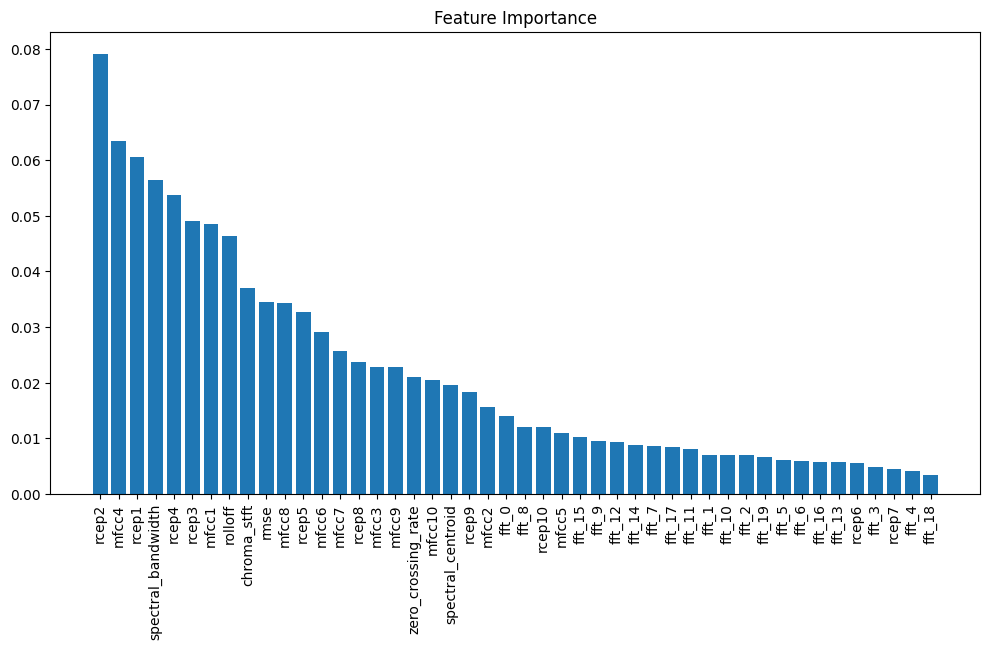

In [29]:

clf = RandomForestClassifier(random_state=0, n_jobs=-1).fit(x_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [x.columns.values[i] for i in indices]
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(x.shape[1]), importances[indices])
plt.xticks(range(x.shape[1]), names, rotation=90)
plt.show()

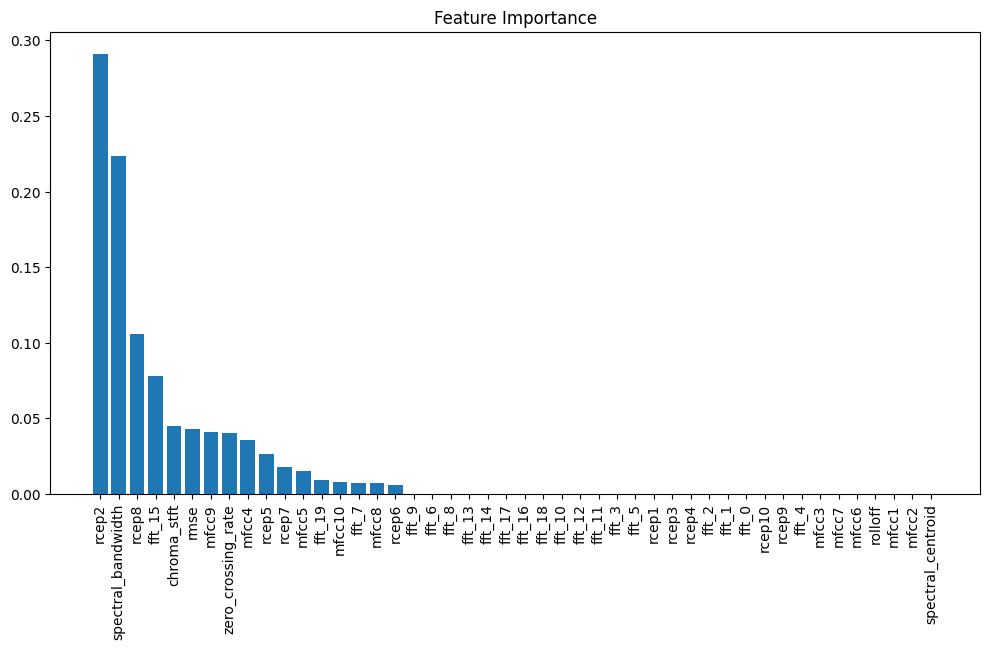

In [30]:
clf = DecisionTreeClassifier(random_state=0).fit(x_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [x.columns.values[i] for i in indices]
plt.figure(figsize=(12,6))
plt.title("Feature Importance")
plt.bar(range(x.shape[1]), importances[indices])
plt.xticks(range(x.shape[1]), names, rotation=90)
plt.show()

On remarque la différence d'importance des features selon le modèle choisit , or qu'avec DecisionTreeClassifier, l'importance est calculée pour un seul arbres tandis qu'avec RandomForestClassifier c'est sur plusieurs arbres càd que le résultat donné par RandomForestClassifier est plus robuste.

On va maintenant visualiser la distribution des features  les plus importantes en fonction des classes.

<Axes: xlabel='rcep2', ylabel='label'>

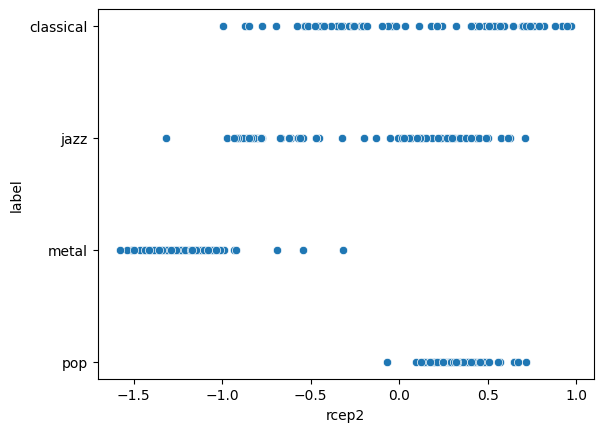

In [8]:
sns.scatterplot(x=x_train['rcep2'], y=data['label'])

<Axes: xlabel='spectral_bandwidth', ylabel='label'>

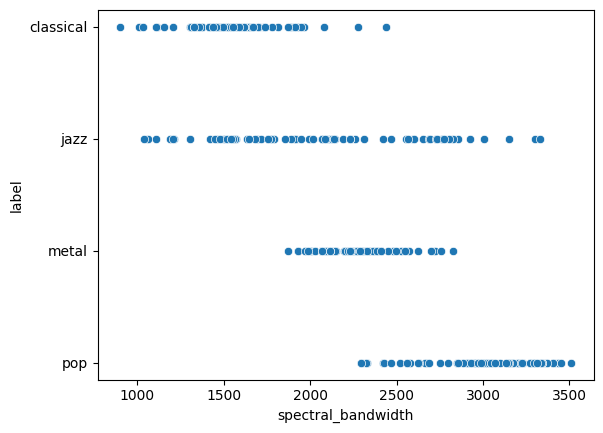

In [9]:
sns.scatterplot(x=x_train['spectral_bandwidth'], y=data['label'])

<Axes: xlabel='rcep1', ylabel='label'>

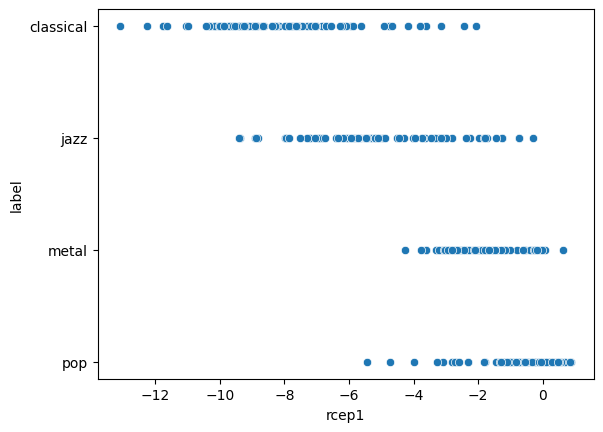

In [10]:
sns.scatterplot(x=x_train['rcep1'],y=data['label'])

Aprés une bonne visualisation des données , on va maintenant passer aux différents modèles et leurs exactitude de prédiction

# On entraine le modèle avec KNN

In [ ]:
param_grid = {
    'n_neighbors': range(4,50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(x_train_scaled, y_train)

print(f"Best parameters for KNN: {grid_search_knn.best_params_}")

Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


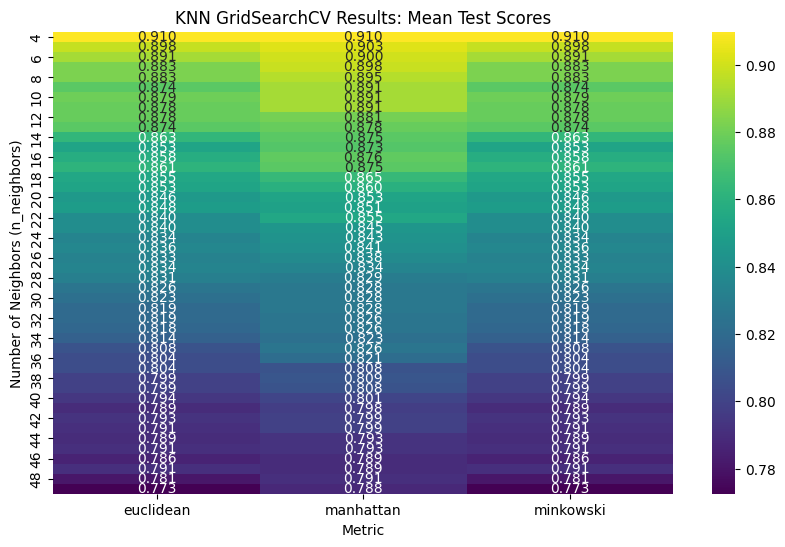

In [ ]:
results = pd.DataFrame(grid_search_knn.cv_results_)

pivot_table = results.pivot_table(
    index='param_n_neighbors', 
    columns='param_metric', 
    values='mean_test_score', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', cbar=True, fmt='.3f')

plt.title('KNN GridSearchCV Results: Mean Test Scores')
plt.xlabel('Metric')
plt.ylabel('Number of Neighbors (n_neighbors)')
plt.show()

Accuracy :0.91


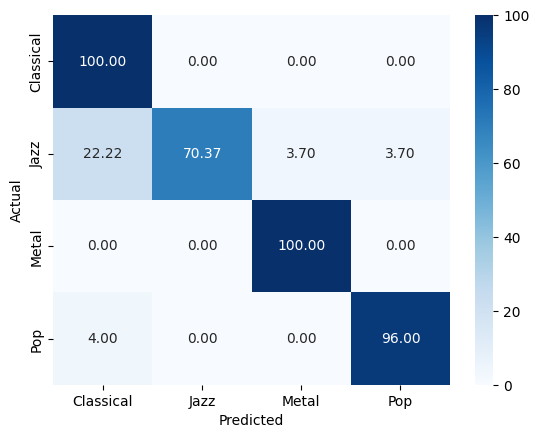

In [39]:
knn = KNeighborsClassifier(n_neighbors = 4,metric='manhattan',weights='distance')
knn.fit(x_train_scaled, y_train)
y_pre=knn.predict(x_test)
print(f"Accuracy :{accuracy_score(y_pre,y_test)}")
class_names=['Classical', 'Jazz', 'Metal', 'Pop']
y_pred=knn.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
parameters = [
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'kernel': ['poly']},
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
]
svm_model=SVC(probability=True)
svm = GridSearchCV( estimator=svm_model,param_grid= parameters, scoring = 'accuracy', cv=5)
svm.fit(x_train_scaled, y_train)
joblib.dump(svm.best_estimator_, 'models/model.pkl')
print("Meilleurs paramètres:", svm.best_params_)
print(f'Accuracy: {accuracy_score(svm.predict(x_test),y_test)}')


Meilleurs paramètres: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.92


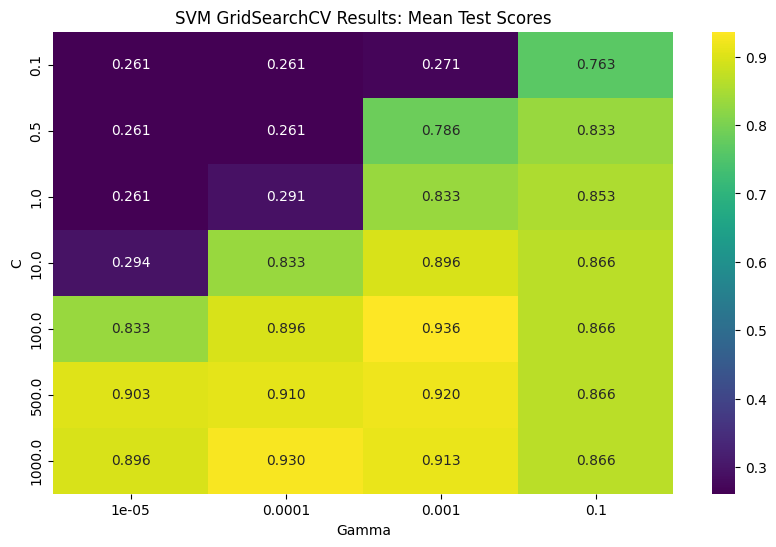

In [ ]:
results = pd.DataFrame(svm.cv_results_)

pivot_table = results.pivot_table(
    index='param_C', 
    columns='param_gamma', 
    values='mean_test_score', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', cbar=True, fmt='.3f')

plt.title('SVM GridSearchCV Results: Mean Test Scores')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.show()

Accuracy: 0.92


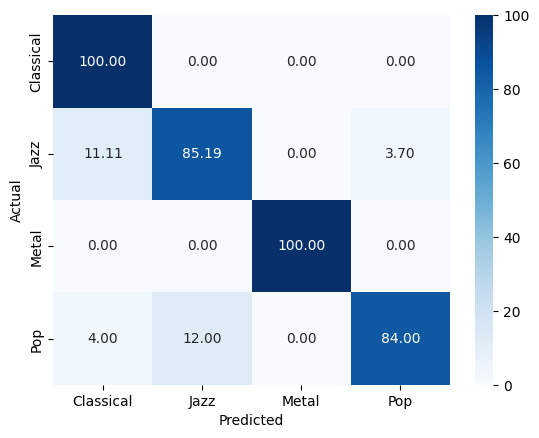

In [40]:
svm = SVC(C=100, gamma=0.001, kernel='rbf')
svm.fit(x_train_scaled, y_train)
y_pred = svm.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred=svm.predict(x_test)
print(f'Accuracy: {accuracy_score(y_pred,y_test)}')
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.93


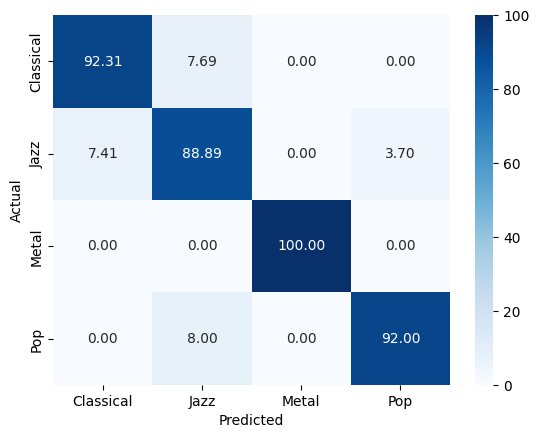

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.86      0.89      0.87        27
           2       1.00      1.00      1.00        22
           3       0.96      0.92      0.94        25

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [41]:

mlp = MLPClassifier(hidden_layer_sizes=(100,400),activation='relu', random_state=2)
mlp.fit(x_train_scaled,y_train)
joblib.dump(mlp, 'models/model1.pkl')
class_names=['Classical', 'Jazz', 'Metal', 'Pop']
y_pred=mlp.predict(x_test)
print(f'Accuracy: {accuracy_score(y_pred,y_test)}')
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred))


In [30]:
mlp = MLPClassifier(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 100),(100.200),(100,400)],  
    'activation': ['relu', 'tanh'], 
}
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)

C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

Best parameters found by GridSearchCV: {'activation': 'relu', 'hidden_layer_sizes': (100, 400)}


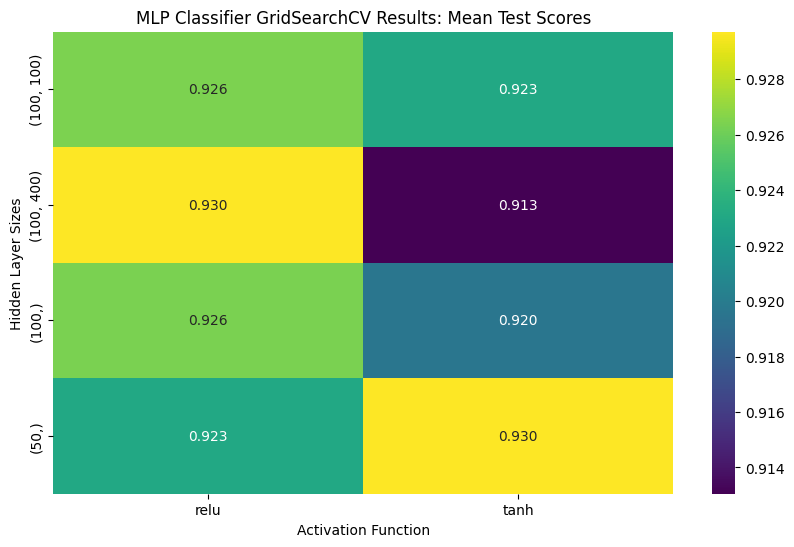

In [36]:
results = pd.DataFrame(grid_search.cv_results_)
results['param_hidden_layer_sizes'] = results['param_hidden_layer_sizes'].apply(str)

pivot_table = results.pivot_table(
    index='param_hidden_layer_sizes',  # Rows for different hidden layer sizes
    columns='param_activation',            # Aggregate by mean score
    values='mean_test_score',          # The mean test scores
    aggfunc='mean'  
)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', cbar=True, fmt='.3f')

# Adding labels and title
plt.title('MLP Classifier GridSearchCV Results: Mean Test Scores')
plt.xlabel('Activation Function')
plt.ylabel('Hidden Layer Sizes')
plt.show()

In [11]:
log = LogisticRegression(random_state=3)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l2', 'l1'],      
    'solver': ['liblinear', 'saga'] 
}

grid_search = GridSearchCV(log, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")

best_log = grid_search.best_estimator_
y_predict = best_log.predict(x_test)

print(f'Accuracy: {accuracy_score(y_predict, y_test)}')

C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: Conve

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.91


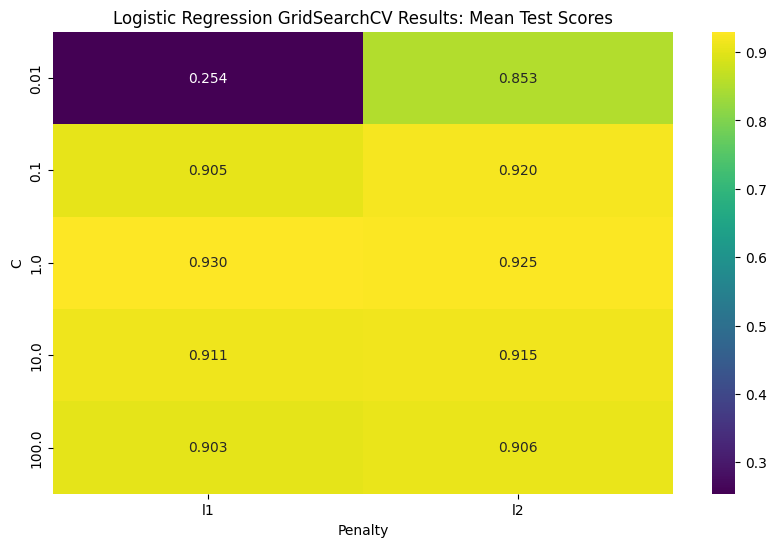

In [22]:
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(
    index='param_C',  # Rows for different values of C
    columns='param_penalty',  # Columns for different penalty types
    values='mean_test_score',  # The test scores
    aggfunc='mean'  # Aggregate by mean score (in case there are multiple cross-validation splits)
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', cbar=True, fmt='.3f')

plt.title('Logistic Regression GridSearchCV Results: Mean Test Scores')
plt.xlabel('Penalty')
plt.ylabel('C')
plt.show()

C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.91


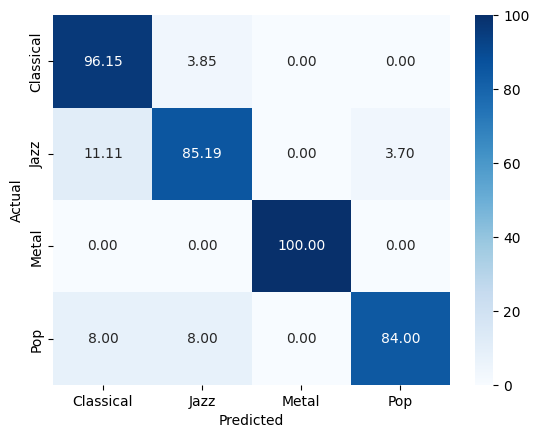

In [42]:
log = LogisticRegression(C=1, penalty='l1', solver='saga')
log.fit(x_train_scaled, y_train)
y_pr=log.predict(x_test)
print(f'Accuracy: {accuracy_score(y_pr,y_test)}')
cm = confusion_matrix(y_test, y_pr)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
